# Reasoning & Learning

**Please, make sure you're running this notebook in a subparent folder of the `aima-python` repository.**

In [ ]:
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

np.random.seed(183242)

# Import probability code from AIMA repository to create a Bayesian Network
sys.path.append('../../../')
from probability import * 

np.set_printoptions(suppress=True) 

## Bayesian Networks

### 1. Provide a visual depiction of the network.

<img src="img/BayesNet.png" width=600 height=600>

### 2. Detail the associated Conditional Probability Tables.

Construct the network:

In [ ]:
research_community = BayesNet([
    # 1. Marginal probability of traffic
    ('Traffic', '', 0.47),
    # 2. Fossil Fuel conditioned on Traffic
    ('FossilFuel', ['Traffic'], {True: 0.67, False: 0.23}),
    # 3. Renewable Energy conditioned on Traffic
    ('RenewableEnergy', ['Traffic'], {True: 0.72, False: 0.52}),
    # 4. Global Warming conditioned on Fossil Fuel
    ('GlobalWarming', ['FossilFuel'], {True: 0.63, False: 0.18}),
    # 5. AI conditioned on Global Warming and Renewable Energy
    ('AI', ['GlobalWarming', 'RenewableEnergy'], 
                    {(True, True): 0.75,
                    (True, False): 0.31,
                    (False, True): 0.36,
                    (False, False): 0.09}),
    # 6. Employed conditioned on AI
    ('Employed', ['AI'], {True: 0.10, False: 0.03})
])

Print the random variables (nodes) of the network:

In [ ]:
research_community.nodes

[('Traffic', ''),
 ('FossilFuel', 'Traffic'),
 ('RenewableEnergy', 'Traffic'),
 ('GlobalWarming', 'FossilFuel'),
 ('AI', 'GlobalWarming RenewableEnergy'),
 ('Employed', 'AI')]

Query to output the CPT for the "AI" node: (or any other node)

In [ ]:
research_community.variable_node('AI').cpt

{(True, True): 0.75,
 (True, False): 0.31,
 (False, True): 0.36,
 (False, False): 0.09}

### 3. Demonstrate querying the network.

In [ ]:
#### Custom function we defined for this part:

def print_probability(true, false, decimals=3):
    """ 
    Perform a clean print of the probabilities of a given query.
    """
    print('P(True): {}, P(False): {}'.format(round(true, decimals), round(false, decimals)))



**Definition of the network:**

$$P(T, FF, GW, RE, AI, E) = P(T) \cdot P(FF|T) \cdot P(GW|FF) \cdot P(RE|T) \cdot P(AI|RE) \cdot P(AI|GW, RE) \cdot P(E)$$

**A basic example of a the join probability distribution using the CPTs:**

$$P(T=false, FF=true, GW=false, RE=true, AI=true, E=false) = 0.00759$$


In [ ]:
# Join probability example (basic query):
print('Probability:', ((1 - 0.47) * 0.23 * (1 - 0.63) * 0.52 * 0.36 * (1 - 0.10)))

Probability: 0.00759895344


Let's prove **conditional independence:**

Whenever we ask for the probability of an event and its parent/s is/are given in the query, the probability will always be the one showing in the Conditional Probability Tables, meaning that the other random variables' possible values have no effect on the final outcome:

Example below: $$P(E | T, FF, RE, GW, AI) = P(E | AI)$$

In [ ]:
ans_dist = enumeration_ask('Employed', {'Traffic': False, # True or False
                                        'FossilFuel': False, # True or False
                                        'RenewableEnergy': False, # True or False
                                        'GlobalWarming': False, # True or False
                                        'AI': False}, research_community)

print_probability(ans_dist[True], ans_dist[False])

P(True): 0.03, P(False): 0.97


**Causal Reasoning:** Given that we were stuck in traffic this morning, what is the probability of seeing a new AI job posted online later in the day?

In [ ]:
ans_dist = enumeration_ask('AI', {'Traffic': True}, research_community)
print_probability(ans_dist[True], ans_dist[False])

P(True): 0.449, P(False): 0.551


**Evidence Reasoning:** We didn't drive to the lab today and worked remotely, but we did notice a new AI position posted online. What is the probability that there were traffic this morning?

In [ ]:
ans_dist = enumeration_ask('Traffic', {'AI': True}, research_community)
print_probability(ans_dist[True], ans_dist[False])

P(True): 0.556, P(False): 0.444


Additionally, we would expect a higher probability if we include Global Warming:

In [ ]:
ans_dist = enumeration_ask('Traffic', {'AI': True, 'GlobalWarming': True}, research_community)
print_probability(ans_dist[True], ans_dist[False])

P(True): 0.637, P(False): 0.363


Some other **query examples** of the netwrok:

Probability of renewable energy charging stations running out of battery given that someone of the research community got employed to research renewable energy:

In [ ]:
ans_dist = enumeration_ask('RenewableEnergy', {'Employed': True}, research_community)
print_probability(ans_dist[True], ans_dist[False])

P(True): 0.715, P(False): 0.285


Probability of fossil fuel consumption being above the daily average given that no AI jobs realted to renewable energy were posted:

In [ ]:
ans_dist = enumeration_ask('FossilFuel', {'AI': False}, research_community)
print_probability(ans_dist[True], ans_dist[False])

P(True): 0.367, P(False): 0.633


Below, the probability of Employed increases as there are more chances that an AI postition was posted online. The two variables are transmitting information to Employed when AI isn't observed:

In [ ]:
print('P(Employed | Renewable Energy)')
ans_dist = enumeration_ask('Employed', {'RenewableEnergy': True}, research_community)
print_probability(ans_dist[True], ans_dist[False])
print('--')
print('P(Employed | Global Warming)')
ans_dist = enumeration_ask('Employed', {'GlobalWarming': True}, research_community)
print_probability(ans_dist[True], ans_dist[False])
print('--')
print('P(Employed | Global Warming, Renewable Energy)')
ans_dist = enumeration_ask('Employed', {'GlobalWarming': True, 'RenewableEnergy': True}, research_community)
print_probability(ans_dist[True], ans_dist[False])

P(Employed | Renewable Energy)
P(True): 0.066, P(False): 0.934
--
P(Employed | Global Warming)
P(True): 0.071, P(False): 0.929
--
P(Employed | Global Warming, Renewable Energy)
P(True): 0.083, P(False): 0.917


This network was also desing thinking in potential educational purposes. **Our example shows 3 basic structures of Bayesian Networks:**

- The first configuration called **Causal Chain** (random variables: RE, AI and E) states that there's no guranteed independance between $Renewable$ $Energy$ and $Employed$ if $AI$ isn't observed. Otherwise, if $AI$ is given, following our conditional independence assumption, $Employed$ is only dependent of $AI$. This can be easly demonstrated when querying the network but also conceptually. Consider the case that a high demand of renewable energy could make one of researchers get employed to work for these companies (they receive a call for a job interview without posting an AI position online). 
- The second structure is called **Common Cause** (random variables: T, FF and RE). Here, there's no guarantee that $Fossil$ $Fuels$ and $Renewable Energy$ aren't independant when $Traffic$ isn't observed. As a matter of fact, the usage of fossil fuels is correlated in some way with the usage of renewal energy e.g. when there are less motor vehicules in the streets burning fossil fuels, citizens of our city may have decided to start driving their electric cars that are charged using the city's solar-powered chargers. However, when traffic is observed, this doesn't make sense in our model anymore i.e. they are independent. 
- Lastly, we find a third configuration called **Common Effect** (random variables: GW, RE, AI). This one states that $Global Warming$ and $Renewal Energy$ are independant if $AI$ isn't observed, and they aren't when $AI$ is given. In our model, random variable $Renewal$ $Energy$ represents the availability of solar-powered charging stations for electric vehicules. There could exist many reason that the availability goes up or down and doesn't necessary means that $Global$ $Warming$ indicators are high or low (e.g. the company that builds these chargers goes bankrupt). However, when there are new jobs in AI for renewable energy research posted online, there exist some sort of correlation between the two random varaibles, as given that the Goverment posted these jobs, the probability that they were also posted by renewable energy companies interested in optimizing their processes using AI has to be lower. 

## Learning: Developing and Evaluating a Model

### Import datasets

**1) Breast Cancer Wisconsin**

In [ ]:
col_names = ['id', 'ClumpThickness', 'UniformityCellSize', 'UniformityCellShape', 'MarginalAdhesion', 
             'SingleEpithelialCellSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleoli', 'Mitoses',
             'Class']

breast_cancer = pd.read_csv('datasets/breast-cancer-wisconsin.csv', header=None)
breast_cancer.columns = col_names
# drop ID column
breast_cancer.drop('id', axis=1, inplace=True) 
# 0: Benign, 1: Malignant
breast_cancer['Class'] = breast_cancer['Class'].map(dict({2:0, 4:1})) 
# Remove NA ('?') values (2% of the dataset)
breast_cancer = breast_cancer.replace("?", np.nan).dropna()
# Convert all variables to numeric
breast_cancer = breast_cancer.apply(pd.to_numeric)
breast_cancer_array = np.array(breast_cancer)
breast_cancer.head()

,ClumpThickness,UniformityCellSize,UniformityCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


**2) Tic-Tac-Toe**

In [ ]:
col_names = ['TopLeftSquare', 'TopMiddleSquare', 'TopRightSquare', 'MiddleLeftSquare', 'MiddleMiddleSquare', 
             'MiddleRightSquare', 'BottomLeftSquare', 'BottomMiddleSquare', 'BottomRightSquare', 'Class']

tictactoe = pd.read_csv('datasets/tic-tac-toe.csv', header=None)
tictactoe.columns = col_names
# 0: X doesn't win, 1: X wins (positive)
tictactoe['Class'] = tictactoe['Class'].map(dict({'positive': 1, 'negative': 0}))

# Convert categorical values with scikit-learn's ordinal encoder 
tictactoe_encoder = OrdinalEncoder()
tictactoe_array = tictactoe_encoder.fit_transform(tictactoe)
np.random.shuffle(tictactoe_array)
tictactoe.head()

,TopLeftSquare,TopMiddleSquare,TopRightSquare,MiddleLeftSquare,MiddleMiddleSquare,MiddleRightSquare,BottomLeftSquare,BottomMiddleSquare,BottomRightSquare,Class
0,x,x,x,x,o,o,x,o,o,1
1,x,x,x,x,o,o,o,x,o,1
2,x,x,x,x,o,o,o,o,x,1
3,x,x,x,x,o,o,o,b,b,1
4,x,x,x,x,o,o,b,o,b,1


In [ ]:
#### Custom function we defined for this part:

def prior_probability(data, class_name, print_results=False, return_priors=False):
    """
    Compute the prior probability of the classes given a dataset and the class label.
    """
    observations = len(data)
    class_label, frequency = np.unique(data[class_name], return_counts=True)
    priors = frequency / observations
    
    if print_results:
        print('Classes:', class_label)
        print('Prior probability:', priors)
    if return_priors:
        return priors

Below we print the prior probabilities for both datasets:

In [ ]:
print("Breast Cancer Wisconsin. 0: Benign, 1: Malignant")
prior_probability(breast_cancer, 'Class', print_results=True, return_priors=False)
print('---')
print("Tic-Tac-Toe. 0: X doesn't win, 1: X wins")
prior_probability(tictactoe, 'Class', print_results=True, return_priors=False)

Breast Cancer Wisconsin. 0: Benign, 1: Malignant
Classes: [0 1]
Prior probability: [0.65007321 0.34992679]
---
Tic-Tac-Toe. 0: X doesn't win, 1: X wins
Classes: [0 1]
Prior probability: [0.34655532 0.65344468]


### Naive Bayes Learner

In [ ]:
#### Custom class we wrote for this part:


class NaiveBayesLearner:
    """
    Naive Bayes algorithm implementation to classify data with categorical features. 
    
    It allows multi-class problems. The model is ready to perform both variants: Multinomial or Bernoulli. 
    - For Multinomial classification, the input features should contain ordinal values.
    - For Bernoulli classification, feature values have to be encoded as One Hot Encoding (binary).
    """
    def __init__(self, data):
        self.data = data
        self.bayes_model = dict()
        self.classes = 0
        self.n_features = 0
        self.n_observations = 0
        self.priors = []
        
        self.calculate_priors()
        
    def calculate_priors(self):
        """
        It calculates the prior probabilities given a dataset. 
        This function is executed when the class is initialized.
        """
        self.n_observations = len(self.data)
        class_label, frequency = np.unique(self.data[:,-1], return_counts=True)
        self.priors = frequency / self.n_observations
        
    def build_model(self, alpha=None, k=2):
        """
        This is the core function of the algorithm. It generates and stores the Naive Bayes model in a dictionary.
        For each pair of class and feature, it computes the conditional probability of observing an specific 
        feature value given the class. 
        
        The algorithm also includes Laplace Smoothing where alpha and k parameters are tunable.
        """
        
        self.classes = np.unique(self.data[:,-1]).astype(int) # Unique values
        self.n_features = self.data[:,:-1].shape[1] # Exclude Class column
        
        if alpha is None:
            alpha = self.n_features

        for class_label in self.classes:
            class_len = len(self.data[self.data[:,-1] == class_label])
            cond_probs_dict = dict()
    
            for i in range(self.n_features): # For each feature:
                # Create an empty dictionary where the values are the possible 
                # values of the feature and the keys are zeros.
                # We also use 1/class_len+2 for laplace smothing to avoid 0 probabilities in the following steps
                conditional_probs = dict((index, alpha/(class_len + (alpha*k))) for index in np.unique(self.data[:,i]))
                # Check unique values in the selected feature given class 'c' and return their frequency
                values, freq = np.unique(self.data[self.data[:, -1] == class_label][:, i], return_counts=True)
                # Calcualte p(x | c)
                prob = (freq + alpha) / (class_len + (alpha*k)) # Laplace Smoothing
    
                # Fill the dictionary with conditional probabilities. If any possible value of the feature has 
                # no presence when class 'c' is given, its frequency will be alpha/class_len+(alpha*k).
                value_index = 0
                for value in values:
                    conditional_probs[value] = prob[value_index]
                    value_index += 1
                # Store the dictionary in the main conditional probabilities dictionary
                # We can then query the dictionary by feature number: x1, x2, x3, ..., xn and value: 1,2,3,...,n
                cond_probs_dict['x' + str(i)] = conditional_probs
            # Store results from class 'c' in the model
            self.bayes_model[class_label] = cond_probs_dict
            
    def calculate_probability(self, query_point, return_bayes_data=False):
        """
        This function computes the likelihood, evidence and class probabilities of a given query point. The bayes 
        model is already built, so it just looks at it to query the data required to perform Bayes' rule.
        """
        likelihood = dict()
        evidence = 0 
        for class_label in self.classes:
            likelihood_op = 1
            for feature_index in range(len(query_point)):
                # Model[ class_label ][ feature ][ feature_value ] gives the cond. probability we're looking for
                query_model = self.bayes_model[class_label]['x' + str(feature_index)][query_point[feature_index]]
                likelihood_op = likelihood_op * query_model
            # Store likelihood and evidence results
            likelihood[class_label] = likelihood_op
            evidence += (likelihood_op * self.priors[class_label])
                
        probs = dict()
        for class_label in self.classes:
            # Performs Bayes' Rule 
            probs[class_label] = (likelihood[class_label] * self.priors[class_label]) / evidence
                
        if return_bayes_data: # Data to manually compute the probability using Bayes' rule
            return likelihood, evidence, self.priors, probs
        else:
            # Return probabilities for all of the classes
            return list(probs.values())
        
    def predict(self, query_instances, prob=False):
        """
        This method is used for queries with more than 1 feature vector (e.g. a test set). It returns
        both the probability of each class and the final predicted class using a 0.5 cut-off value.
        """
        try:
            query_instances.shape[1]
        except:
            raise ValueError('Input must be a list or Numpy array.')

        results = []
        for instance in query_instances: # Make predictions for each feature vector
            pred = self.calculate_probability(instance)
            # Store the predictions in a list
            results.append(pred)
        if prob:
            return results
        else:
            # Return class with higher probability:
            return np.argmax(results, axis=1)

## Q-2.1: Data

**Subset of the data (60 rows):** Compute:
- the prior probabilities for each of the classes.
- the probability of evidence.
- the probability of likelihood of evidences.

$${\displaystyle P(Class|F_{i})={\frac {P(F_{i}|Class)P(Class)}{P(F_{i})}}}$$

$$where:$$

$$P(F_{i}|Class): Likelihood.$$
$$P(Class): Prior.$$
$$P(F_{i}): Evidence.$$
$$P(Class|F_{i}): Posterior.$$

`calculate_probability` method has been specifically design to query **(i)** the prior probabilities of the model,
**(ii)** the likelihood of the classes, **(iii)** the probability of evidence and, **(iv)** the probability of belonging to each class. As mentioned in the report, we use a an observation example to calculate these components in the Bayes' Rule formula. 

**1) Breast Cancer Wisconsin**

In [ ]:
subset = breast_cancer_array[:60,:] # Subset of data
model = NaiveBayesLearner(subset) # Instance of the learner
model.build_model() # Build the model (Laplace Smoothing is applied to conditional proabilities, where
# alpha is equal to the number of features in the dataset)

# Query probabilities:
query_point = breast_cancer_array[61,:-1]
# 'calculate_probability' outputs the data we're looking for:
likelihood, evidence, priors, probs = model.calculate_probability(query_point, return_bayes_data=True)

print("Breast Cancer Wisconsin.")
print('----')
print('Prior Probability:', priors)
print('Likelihood:', likelihood)
print('Evidence:', evidence)
print('Posterior Probability:', probs)

Breast Cancer Wisconsin.
----
Prior Probability: [0.51666667 0.48333333]
Likelihood: {0: 1.940144506318316e-05, 1: 9.44079198443004e-06}
Evidence: 1.4587129408452486e-05
Posterior Probability: {0: 0.6871866059886235, 1: 0.3128133940113766}


**2) Tic-Tac-Toe**

In [ ]:
subset = tictactoe_array[:60,:] # Subset of data
model = NaiveBayesLearner(subset) # Instance of the learner
model.build_model() # Build the model (Laplace Smoothing is applied to conditional proabilities, where
# alpha is equal to the number of features in the dataset)

# Query probabilities:
query_point = tictactoe_array[61,:-1]
# 'calculate_probability' outputs the data we're looking for:
likelihood, evidence, priors, probs = model.calculate_probability(query_point, return_bayes_data=True)

print("Tic-Tac-Toe.")
print('----')
print('Prior Probability:', priors)
print('Likelihood:', likelihood)
print('Evidence:', evidence)
print('Posterior Probability:', probs)

Tic-Tac-Toe.
----
Prior Probability: [0.31666667 0.68333333]
Likelihood: {0: 0.00023343842616940124, 1: 0.00027545784631932414}
Evidence: 0.00026215169660518187
Posterior Probability: {0: 0.28198241416804115, 1: 0.7180175858319588}


**Tic-Tac-Toe dataset suitability**

We're going to feed the model with more data and demonstrate why the assumption of conditional independence may not work on this dataset (the pdf report goes exhaustively through this issue):

In [ ]:
subset = tictactoe_array[:600,:] # Re-calculate probabilities using more data
model = NaiveBayesLearner(subset) # Instance of the learner
model.build_model() # Build the model (Laplace Smoothing is applied to conditional proabilities, where
# alpha is equal to the number of features in the dataset)

Below we show all the conditional probabilities that are used to calcualte the likelihood $P(F_{i}|Class)$. It is a dictionary with the following structure and levels:

$Class$ --> $Feature$ ---> $Feature Value$ --- > Conditional probability of $Feature$ taking $Feature Value$ given the $Class$.

E.g. $Class = 0$, $Feature=X_{1}$, $Feature Value = 2$, $P(F_{1} = 2|Class = 0) = 0.4776$

In [ ]:
# Conditional probabilities to work out the entire Bayes' Rule:
model.bayes_model

{0: {'x0': {0.0: 0.22767857142857142,
   1.0: 0.44642857142857145,
   2.0: 0.36607142857142855},
  'x1': {0.0: 0.23660714285714285,
   1.0: 0.32589285714285715,
   2.0: 0.47767857142857145},
  'x2': {0.0: 0.21875, 1.0: 0.44642857142857145, 2.0: 0.375},
  'x3': {0.0: 0.26339285714285715, 1.0: 0.3125, 2.0: 0.4642857142857143},
  'x4': {0.0: 0.16071428571428573,
   1.0: 0.5758928571428571,
   2.0: 0.30357142857142855},
  'x5': {0.0: 0.27232142857142855, 1.0: 0.33035714285714285, 2.0: 0.4375},
  'x6': {0.0: 0.20089285714285715, 1.0: 0.4375, 2.0: 0.4017857142857143},
  'x7': {0.0: 0.2544642857142857, 1.0: 0.3169642857142857, 2.0: 0.46875},
  'x8': {0.0: 0.23214285714285715, 1.0: 0.4330357142857143, 2.0: 0.375}},
 1: {'x0': {0.0: 0.22572815533980584,
   1.0: 0.3131067961165049,
   2.0: 0.4830097087378641},
  'x1': {0.0: 0.28398058252427183,
   1.0: 0.3786407766990291,
   2.0: 0.3592233009708738},
  'x2': {0.0: 0.25485436893203883,
   1.0: 0.2815533980582524,
   2.0: 0.4854368932038835},
  'x

We take the conditional probabilities for all features and feature values fiven class 1 i.e. X wins (positive). And then plot the results on a Tic-Tac-Toe board (scatter plot using different markers).

In [ ]:
class_label = 1 # X Wins
feature_value = [0, 1, 2] # Blank, O or X
prob = dict()
for value in feature_value:
    cp_win = []
    for feature in range(9):
        cp_win.append(model.bayes_model[class_label]['x' + str(feature)][value])
    prob[value] = cp_win

In [ ]:
def plot_tictactoe_board(conditional_probabilities, class_label, title, mark, save=False):
    # Tic-Tac-Toe board:
    x = [2,2,2,1,1,1,0,0,0]
    y = [0,1,2,0,1,2,0,1,2]
    # Use scatter plot to visualize the board:
    plt.figure(figsize=(9,7))
    plt.scatter(x, y, c=conditional_probabilities[class_label], s=7000, cmap='viridis', marker=mark)
    plt.colorbar()
    plt.xticks(x)
    plt.yticks(y)
    plt.margins(x=0.2)
    plt.margins(y=0.2)
    plt.title(title,  fontsize=16)
    # Plot as text the conditional probabilities on each maker:
    for i in range(len(x)):
        plt.text(x[i]-(0.115),y[i], round(conditional_probabilities[class_label][i],2), color='white', fontsize=14)
        
    if save:
        plt.savefig('SavedImage.png', dpi=400)
        
    plt.show()

**Probability that X is at any of the squares below given that X wins the game.**

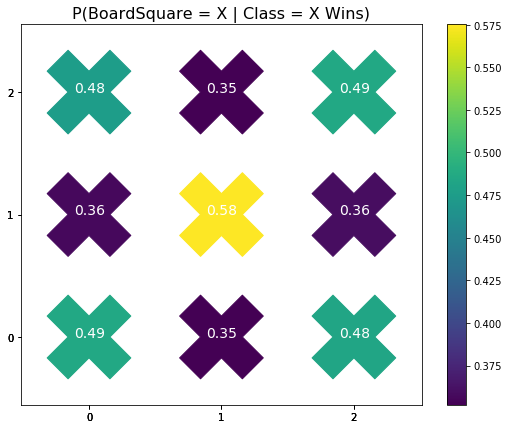

In [ ]:
plot_tictactoe_board(conditional_probabilities=prob, 
                     class_label=2, 
                     title='P(BoardSquare = X | Class = X Wins)', 
                     mark='X')

**Probability that O is at any of the squares below given that X wins the game.**

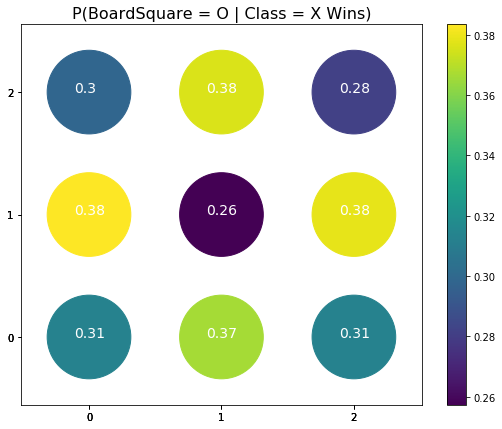

In [ ]:
plot_tictactoe_board(conditional_probabilities=prob, 
                     class_label=1, 
                     title='P(BoardSquare = O | Class = X Wins)', 
                     mark='o')

**Probability that neither X or O is at any of the squares below (blank square) given that X wins the game.**

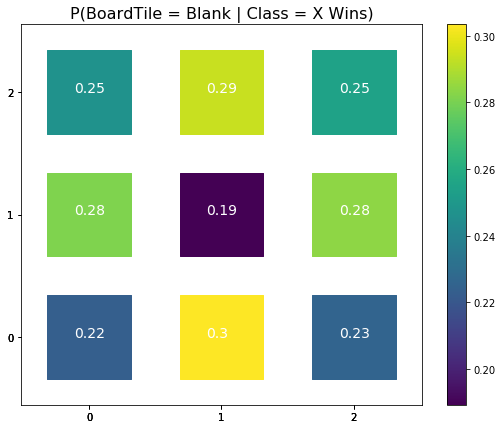

In [ ]:
plot_tictactoe_board(conditional_probabilities=prob, 
                     class_label=0, 
                     title='P(BoardTile = Blank | Class = X Wins)', 
                     mark='s')

**Explanation in the pdf report:** There's only one conditional probability that makes the difference, which is being at the middle center square. When there's an X at this position there's a 58% probability that X wins, if there's an O, the probability drops to 26%, and when it's blank there's a 19% probability that X wins. However, the conditional probabilities for other locations are very similar for X, O and Blank, which doesn't add relevant information into the calculation of likelihood and evidence. Hence, only 1 out of 9 conditional probabilities are useful. Please, consider any of the adjacent squares to the middle center square and compare the conditional probabilities given in the charts for X and O. For instance, top middle, middle right, middle left and bottom middle squares show almost the same conditional probability for both marks X and 0, which means that X has the same probability of winning whether an X or O is at this square. This demonstrates that the conditional independence assumption in Bayes' Rule doesn't capture the interdependencies in the features. Ultimately, in this game, you make your move decisions based on the current state of the board, which means that all the squares are dependent on each other.

## Naive Bayes Learner

In [ ]:
def train_test_split(data, percentage):
    """
    Simple implementation of train/test split.
    """
    train_len = round(len(data)*percentage)
    train = data[:train_len,:]
    test = data[(train_len+1):,:]
    
    return train, test

def accuracy(y_pred, y_true):
    """
    Simple impementation of level of accuracy.
    """
    return sum(y_pred == y_true)/len(y_pred)

### Evaluation

**1) Breast Cancer Wisconsin**

In [ ]:
train_cancer, test_cancer = train_test_split(breast_cancer_array, percentage=0.8)
model = NaiveBayesLearner(train_cancer) # Instance of the learner
model.build_model() # Build the model (Laplace Smoothing is applied to conditional proabilities, where
# alpha is equal to the number of features in the dataset)

pred = model.predict(test_cancer[:,:-1], prob=False)
print('Baseline Accuracy on test set:', round(accuracy(y_pred=np.array(len(pred)*[0]), y_true=test_cancer[:,-1]) * 100,3))
print('Model Accuracy on test set:', round(accuracy(y_pred=pred, y_true=test_cancer[:,-1]) * 100,3))

Baseline Accuracy on test set: 74.265
Model Accuracy on test set: 98.529


**2) Tic-Tac-Toe**

In [ ]:
train_tictactoe, test_tictactoe = train_test_split(tictactoe_array, percentage=0.8)
model = NaiveBayesLearner(train_tictactoe) # Instance of the learner
model.build_model() # Build the model (Laplace Smoothing is applied to conditional proabilities, where
# alpha is equal to the number of features in the dataset)

pred = model.predict(test_tictactoe[:,:-1], prob=False)
# Baseline accuracy is always predicting the majority class, in this case, X Wins (positive, 1)
print('Baseline Accuracy on test set:', round(accuracy(y_pred=np.array(len(pred)*[1]), y_true=test_tictactoe[:,-1]) * 100,3))
print('Model Accuracy on test set:', round(accuracy(y_pred=pred, y_true=test_tictactoe[:,-1]) * 100,3))

Baseline Accuracy on test set: 64.921
Model Accuracy on test set: 68.063


### Further Investigation (I): Laplace Smoothing

The formula below shows the conditional probability using Laplace Smoothing, where $\alpha$ is a parameter to tune and $k$ is a constant.

$${\displaystyle P(F_{i} = x_{i}|Class = c_{i})={\frac {N_{xici}+\alpha}{N_{ci} + (\alpha \cdot k)}}}$$

**1) Breast Cancer Wisconsin**

In [ ]:
test_runs = []

for i in range(0,4000, 10):
    model = NaiveBayesLearner(train_cancer)
    model.build_model(alpha=i) 
    pred = model.predict(test_cancer[:,:-1], prob=False)
    test_runs.append(accuracy(y_pred=pred, y_true=test_cancer[:,-1])*100)

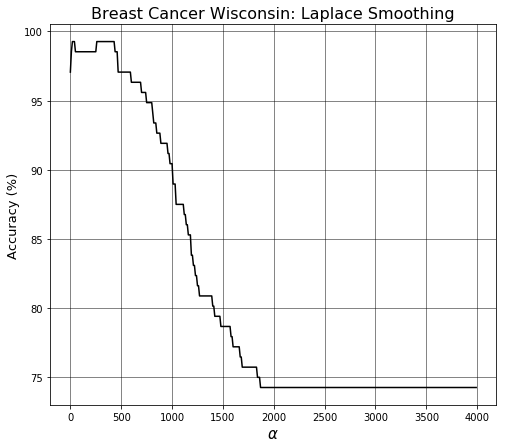

In [ ]:
plt.figure(figsize=(8,7))
plt.plot(range(0,4000, 10), test_runs, c='black')
plt.grid(True, c='black', alpha=0.6)
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=13)
plt.title('Breast Cancer Wisconsin: Laplace Smoothing', fontsize=16);

**2) Tic-Tac-Toe**

In [ ]:
test_runs = []

for i in range(0,4000, 10): 
    model = NaiveBayesLearner(train_tictactoe)
    model.build_model(alpha=i)
    pred = model.predict(test_tictactoe[:,:-1], prob=False)
    test_runs.append(accuracy(y_pred=pred, y_true=test_tictactoe[:,-1])*100)

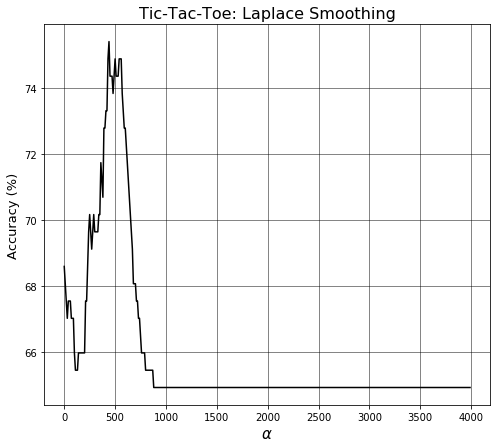

In [ ]:
plt.figure(figsize=(8,7))
plt.plot(range(0,4000, 10), test_runs, c='black')
plt.grid(True, c='black', alpha=0.6)
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=13)
plt.title('Tic-Tac-Toe: Laplace Smoothing', fontsize=16);

**Why do we see a constant level accuracy for large values of $\alpha$?**

Conditional probabilities given by $P(F_{i} = x_{i}|Class = c_{i})$ are approximately 0.5 when $\alpha$ is sufficiently large. In the charts, this is represented by a horizontal straight line when the level of accuracy is constant for any value of $\alpha$. This can be easily proven using the following example where $\alpha =  3000$ and $k = 2$.
  
$${\displaystyle P(F_{i} = x_{i}|Class = c_{i})={\frac {100+3000}{300 + (3000 \cdot 2)}}} \approx 0.5 $$


Hence, when applying Bayes' Rule, the likelihood for both classes will be essentially the same and the selected class will be only based on the prior probabilities (just like the *Baseline Accuracy model*).

### Further Investigation (II): Multinomial vs Bernoulli variants of the model

In this section we experiment with two variants of the learner: Multinomial and Bernoulli. Multinomial classification is the one we previously used to calculate probabilities and test different parameters of Laplace Smoothing. Firstly, we run the model under the Bernoulli variant using binary features and no Laplace Smoothing.

**Bernoulli and Laplace Smoothing $(\alpha = 0)$**

**1) Breast Cancer Wisconsin**

In [ ]:
# 1) Encode variables using OneHotEncoding to perform Bernoulli Classification:

train_cancer, test_cancer  = train_test_split(breast_cancer_array, percentage=0.80)
# Train
ohencoder = OneHotEncoder(sparse=False, categories='auto')
encoded_features_train = ohencoder.fit_transform(train_cancer[:,:-1])
train_cancer_data = np.append(encoded_features_train, train_cancer[:,-1].reshape(len(train_cancer),1), axis=1)
# Test
ohencoder = OneHotEncoder(sparse=False, categories='auto')
encoded_features_test = ohencoder.fit_transform(test_cancer[:,:-1])
test_cancer_data = np.append(encoded_features_test, test_cancer[:,-1].reshape(len(test_cancer),1), axis=1)


# 2) Train and test the model
model_c = NaiveBayesLearner(train_cancer_data) 
model_c.build_model(alpha=0) # Build the model (Laplace Smoothing is NOT applied)

pred = model_c.predict(test_cancer_data[:,:-1], prob=False)
print('Baseline Accuracy on test set:', round(accuracy(y_pred=np.array(len(pred)*[0]), y_true=test_cancer_data[:,-1]) * 100,3))
print('Accuracy on  test set:', round(accuracy(y_pred=pred, y_true=test_cancer_data[:,-1]) * 100,3))

Baseline Accuracy on test set: 74.265
Accuracy on  test set: 26.471


**2) Tic-Tac-Toe**

In [ ]:
# 1) Encode variables using OneHotEncoding to perform Bernoulli Classification:

# Train
ohencoder = OneHotEncoder(sparse=False, categories='auto')
encoded_features_train = ohencoder.fit_transform(train_tictactoe[:,:-1])
train_tictactoe_data = np.append(encoded_features_train, train_tictactoe[:,-1].reshape(len(train_tictactoe),1), axis=1)
# Test
ohencoder = OneHotEncoder(sparse=False, categories='auto')
encoded_features_test = ohencoder.fit_transform(test_tictactoe[:,:-1])
test_tictactoe_data = np.append(encoded_features_test, test_tictactoe[:,-1].reshape(len(test_tictactoe),1), axis=1)


# 2) Train and test the model
model_ttt = NaiveBayesLearner(train_tictactoe_data)
model_ttt.build_model(alpha=0) # Build the model (Laplace Smoothing is NOT applied)

pred = model_ttt.predict(test_tictactoe_data[:,:-1], prob=False)
print('Baseline Accuracy on test set:', round(accuracy(y_pred=np.array(len(pred)*[1]), y_true=test_tictactoe[:,-1]) * 100,3))
print('Accuracy Test:', round(accuracy(y_pred=pred, y_true=test_tictactoe_data[:,-1]) * 100,3))

Baseline Accuracy on test set: 64.921
Accuracy Test: 67.539


**Breast Cancer Wisconsin - Very low accuracy, why?**

In [ ]:
likelihood, evidence, priors, probs  = model_c.calculate_probability(test_cancer_data[1,:-1], return_bayes_data=True)
print('Prior Probability:', priors)
print('Likelihood:', likelihood)
print('Evidence:', evidence)
print('Posterior Probability:', probs)

Prior Probability: [0.62637363 0.37362637]
Likelihood: {0: 0.0, 1: 2.6045803263619245e-17}
Evidence: 9.731399021572026e-18
Posterior Probability: {0: 0.0, 1: 1.0}


In [ ]:
model_c.bayes_model

{0: {'x0': {0.0: 0.6842105263157895, 1.0: 0.3157894736842105},
  'x1': {0.0: 0.8888888888888888, 1.0: 0.1111111111111111},
  'x2': {0.0: 0.804093567251462, 1.0: 0.195906432748538},
  'x3': {0.0: 0.847953216374269, 1.0: 0.15204678362573099},
  'x4': {0.0: 0.8245614035087719, 1.0: 0.17543859649122806},
  'x5': {0.0: 0.9619883040935673, 1.0: 0.038011695906432746},
  'x6': {0.0: 1.0, 1.0: 0.0},
  'x7': {0.0: 0.9883040935672515, 1.0: 0.011695906432748537},
  'x8': {0.0: 1.0, 1.0: 0.0},
  'x9': {0.0: 1.0, 1.0: 0.0},
  'x10': {0.0: 0.1871345029239766, 1.0: 0.8128654970760234},
  'x11': {0.0: 0.9122807017543859, 1.0: 0.08771929824561403},
  'x12': {0.0: 0.9298245614035088, 1.0: 0.07017543859649122},
  'x13': {0.0: 0.97953216374269, 1.0: 0.02046783625730994},
  'x14': {0.0: 1.0, 1.0: 0.0},
  'x15': {0.0: 1.0, 1.0: 0.0},
  'x16': {0.0: 0.9970760233918129, 1.0: 0.0029239766081871343},
  'x17': {0.0: 0.9970760233918129, 1.0: 0.0029239766081871343},
  'x18': {0.0: 0.9970760233918129, 1.0: 0.0029239

With Bernoulli and no Laplace Smoothing, the variables that were originally categorical have become binary, hence the conditional probabilities are skewed to the binary value `False` or 0 - as they aren't binary by nature, we would usually find more *zeros* than *ones* in each column. This, along to the fact that the size of the dataset has increased drastically due to the new binary feature encoding, makes that for any new instance, if there's at least one value set to `True` in any of the binary features (which has to necessarily occur), the product of the conditional probabilities will be approximately 0. **Essentially, we're performing the product of too many extremely small numbers and our machines aren't able to handle them.** We finally end up in a scenario where the denominator of the Bayes' Rule is 0, thus, the posterior probability of the negative class (Benignt) is always 0 and the model predicts Malignant for every new observation.

**Bernoulli and Laplace Smoothing $(\alpha = number\:of\:features)$**

**1) Breast Cancer Wisconsin**

In [ ]:
# Re-run the model where alpha is the number of features:
alpha_n_features = train_cancer_data[:,:-1].shape[1]

model_c = NaiveBayesLearner(train_cancer_data)
model_c.build_model(alpha=alpha_n_features) 
# Build the model (Laplace Smoothing is applied to conditional 
# proabilities, where alpha is equal to the number of features in the dataset)

pred = model_c.predict(test_cancer_data[:,:-1], prob=False)
print('Baseline Accuracy on test set:', round(accuracy(y_pred=np.array(len(pred)*[0]), y_true=test_cancer_data[:,-1]) * 100,3))
print('Accuracy on  test set:', round(accuracy(y_pred=pred, y_true=test_cancer_data[:,-1]) * 100,3))

Baseline Accuracy on test set: 74.265
Accuracy on  test set: 92.647


When the $\alpha$ parameter is set to the number of features, the Bernoulli model shows a much higher level of accuracy on this dataset, but still lower compared to the Multinomial.

**2) Tic-Tac-Toe**

In [ ]:
# Re-run the model where alpha is the number of features:
alpha_n_features = train_tictactoe[:,:-1].shape[1]

model_ttt = NaiveBayesLearner(train_tictactoe_data) 
model_ttt.build_model(alpha=alpha_n_features) 
# Build the model (Laplace Smoothing is applied to conditional 
# proabilities, where alpha is equal to the number of features in the dataset)

pred = model_ttt.predict(test_tictactoe_data[:,:-1], prob=False)
print('Baseline Accuracy on test set:', round(accuracy(y_pred=np.array(len(pred)*[1]), y_true=test_tictactoe_data[:,-1]) * 100,3))
print('Accuracy on  test set:', round(accuracy(y_pred=pred, y_true=test_tictactoe_data[:,-1]) * 100,3))

Baseline Accuracy on test set: 64.921
Accuracy on  test set: 67.539
